In [2]:
import pandas as pd
from sklearn import preprocessing
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

ModuleNotFoundError: No module named 'tensorflow_probability'

In [3]:
x=pd.read_csv("./BIKED_processed.csv", index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: './BIKED_processed.csv'

In [4]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.values)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns,index=x.index.values).astype('float32')

NameError: name 'x' is not defined

In [7]:
with open("images.npy", 'rb') as f:
    images = np.load(f)

In [8]:
param_train, param_val, image_train, image_val = train_test_split(x_scaled, images, test_size=0.2, random_state=42)
image_train=tf.cast(tf.expand_dims(image_train, -1), tf.float32)
image_val=tf.cast(tf.expand_dims(image_val, -1), tf.float32)

In [9]:
def custom_sigmoid_cross_entropy_loss_with_logits(x_true, x_recons_logits):
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true, logits=x_recons_logits)
    if len(np.shape(x_true))==4:
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
    else:
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1])
    return tf.math.reduce_mean(neg_log_likelihood)

In [10]:
class imVAE:
    def __init__(self, imdims, latent_dim, kl_weight, learning_rate):
        self.dim_x = imdims
        self.latent_dim = latent_dim
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
    def encoder(self):
#         # define prior distribution for the code, which is an isotropic Gaussian
#         prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(self.latent_dim), scale=1.), 
#                                 reinterpreted_batch_ndims=1)
        
        model = tf.keras.Sequential(name='encoder')
        model.add(tf.keras.layers.InputLayer(input_shape=self.dim_x))
        
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2),name="e1"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.1))
        
        model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(5, 5),name="e2"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.1))
        
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(tfp.layers.IndependentNormal.params_size(self.latent_dim), name="e3"))
        
        model.add(tfp.layers.IndependentNormal(self.latent_dim, convert_to_tensor_fn=tfp.distributions.Distribution.sample, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=self.kl_weight), name="e4"))
        return model
    
    def decoder(self):
        model = tf.keras.Sequential(name='decoder')
        model.add(tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)))

        model.add(tf.keras.layers.Dense(30*65*32, name="layer1"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.Reshape(target_shape=(30, 65, 32)))
        model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',name="d1"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())

        model.add(tf.keras.layers.Dropout(0.1))

        model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',name="d2"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.1))

#         model.append(layers.UpSampling2D((2,2)))
#         model.append(layers.Conv2D(filters=96, kernel_size=3, strides=(1,1),name="d1"))
#         model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())

#         model.append(layers.UpSampling2D((2,2)))
#         model.append(layers.Conv2D(filters=96, kernel_size=3, strides=(1,1),name="d2"))
#         model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())

        model.add(tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same',name="d3"))
        
#         model.append(keras.layers.Flatten())
#         model.append(tfp.layers.IndependentBernoulli(self.dim_x, name='x_layer'))

        return model
    
    def build_vae_keras_model(self):
        x_input = tf.keras.Input(shape=self.dim_x)
        encoder = self.encoder()
        decoder = self.decoder()
#         encoder.summary()
#         decoder.summary()
        z = encoder(x_input)
        output=decoder(z)

        negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
        
        # compile VAE model
        model = tf.keras.Model(inputs=x_input, outputs=output)
        model.compile(loss=custom_sigmoid_cross_entropy_loss_with_logits, optimizer=tf.keras.optimizers.Adam(self.learning_rate))
        return model


In [11]:
dim_x=len(param_train.columns)
dim_y=np.shape(image_train[1])
imageVAE=imVAE(dim_y, 32, 1, 1e-4).build_vae_keras_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
imhistory = imageVAE.fit(x=image_train, y=image_train, epochs=200, batch_size=32, validation_data=(image_val, image_val),shuffle=True, callbacks=[callback])


Epoch 1/200
113/113 [==============================] - 10s 62ms/step - loss: 16505.8027 - val_loss: 18020.3984
Epoch 2/200
113/113 [==============================] - 6s 57ms/step - loss: 9341.1250 - val_loss: 13493.4531
Epoch 3/200
113/113 [==============================] - 6s 57ms/step - loss: 7969.5933 - val_loss: 10728.4365
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 7417.0293 - val_loss: 8189.6885
Epoch 5/200
113/113 [==============================] - 7s 60ms/step - loss: 7127.8252 - val_loss: 6842.2510
Epoch 6/200
113/113 [==============================] - 7s 60ms/step - loss: 6920.4302 - val_loss: 6483.3984
Epoch 7/200
113/113 [==============================] - 7s 60ms/step - loss: 6785.4502 - val_loss: 6380.0371
Epoch 8/200
113/113 [==============================] - 7s 60ms/step - loss: 6653.4297 - val_loss: 6304.1338
Epoch 9/200
113/113 [==============================] - 7s 60ms/step - loss: 6551.7905 - val_loss: 6284.6040
Epoch 10/200
113/113 [=

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


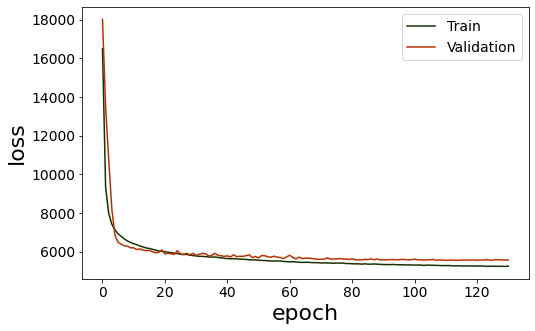

In [12]:
from matplotlib.pyplot import figure
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.rc('axes', labelsize=22)     # fontsize of the axes title
plt.rc('axes', titlesize=22) 
figure(figsize=(8, 5))
plt.plot(imhistory.history['loss'],color='#173000')
plt.plot(imhistory.history['val_loss'], color='#b73000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


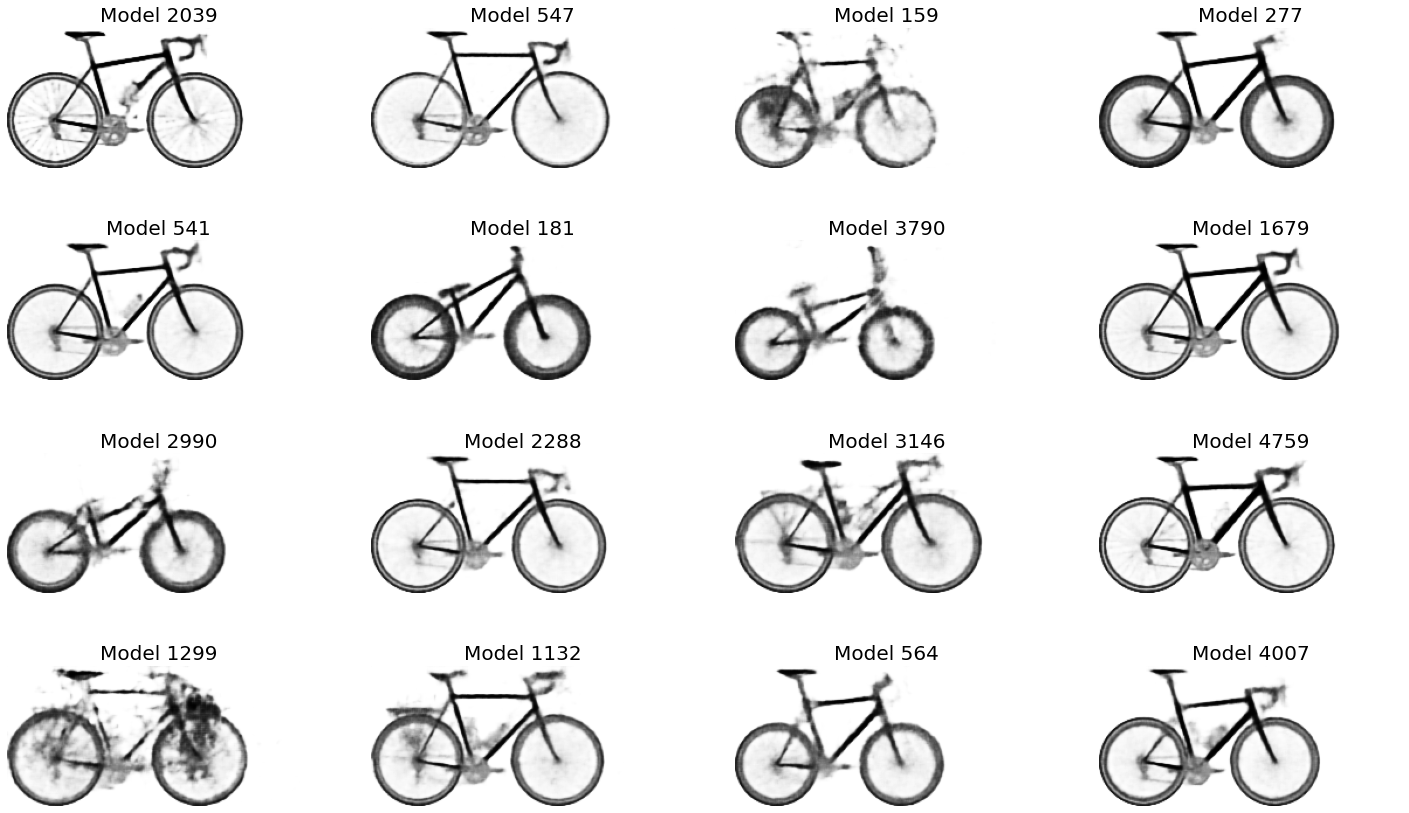

In [13]:
preds=(tf.math.sigmoid(imageVAE.predict(x=image_val[:16])))
fig = plt.figure(figsize=(25, 15))
for i in range(16):
    idx=param_val.index[i]
    plt.subplot(4, 4, i + 1)
    plt.imshow(preds[i,:,:,:], cmap="gray")
    plt.title("Model " + str(idx), fontsize=20)
    plt.axis('off')

In [14]:
latent_train=imageVAE.layers[1].predict(image_train)
latent_val=imageVAE.layers[1].predict(image_val)

In [15]:
# Regressor = MLPRegressor(hidden_layer_sizes=(200, 200), max_iter=5000)
Regressor = LinearRegression()
# KNN = KNeighborsRegressor(n_neighbors=5)
Regressor.fit(param_train, latent_train)
score= Regressor.score(param_val, latent_val)

print("Coefficient of Determination (R2): " + str(100*score) + "%")



Coefficient of Determination (R2): -2891844.000745654%


In [16]:
score= Regressor.score(param_train, latent_train)

print("Coefficient of Determination (R2): " + str(100*score) + "%")

Coefficient of Determination (R2): 78.5243836914527%


In [17]:
def plotcomparison(preds, actual, indices):
    fig = plt.figure(figsize=(25, 15))
    for i in range(16):
        if i%2==1:
            idx=indices[i//2]
            plt.subplot(4, 4, i + 1)
            plt.imshow(preds[i//2,:,:,:], cmap="gray")
            plt.title("Model " + str(idx), fontsize=20)
            plt.axis('off')
        else:
            idx=indices[i//2]
            plt.subplot(4, 4, i + 1)
            plt.imshow(actual[i//2,:,:,:], cmap="gray")
            plt.title("Model " + str(idx), fontsize=20)
            plt.axis('off')

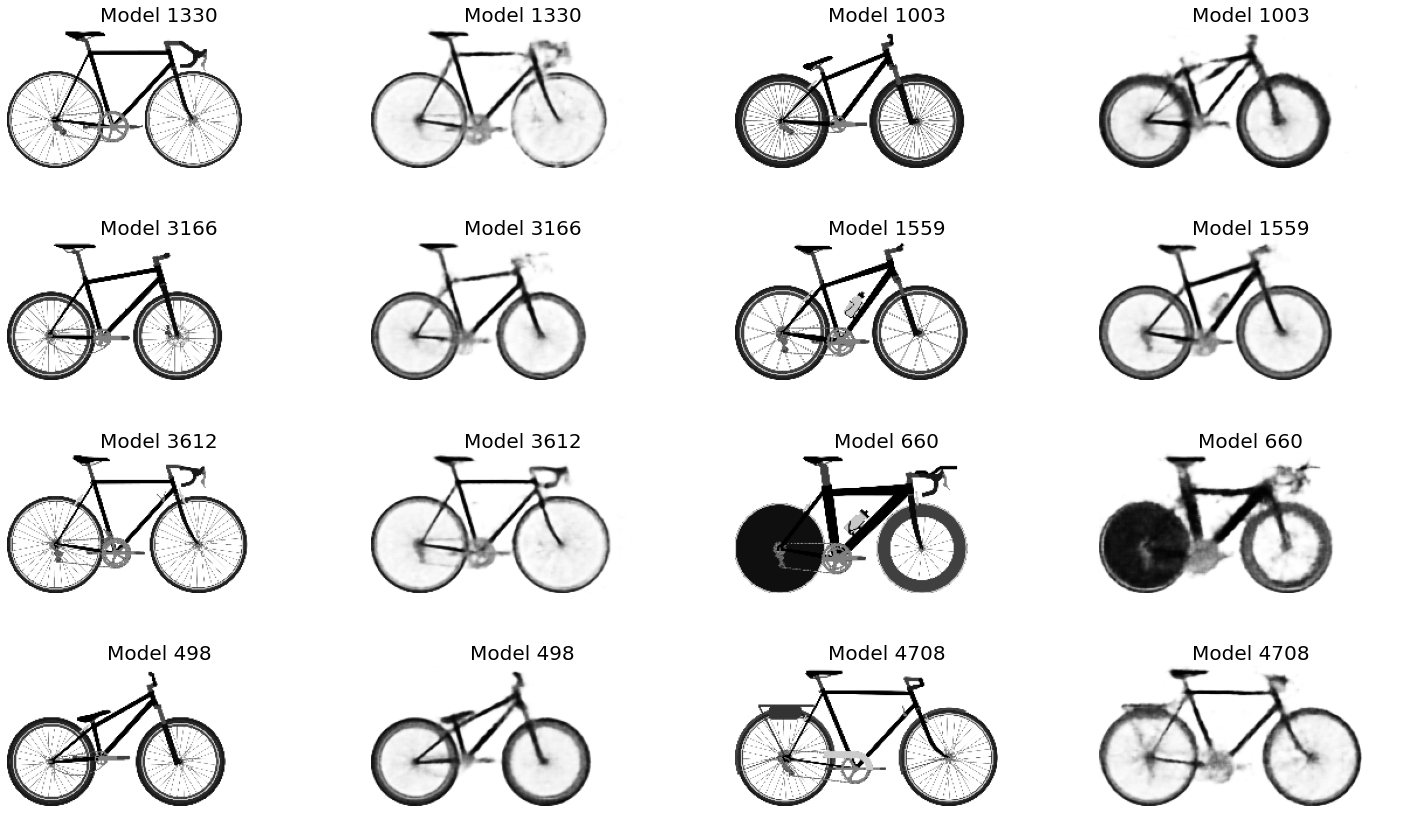

In [18]:
preds=tf.sigmoid(imageVAE.layers[2].predict(Regressor.predict(param_train[:8])))
plotcomparison(preds, image_train[:8], param_train.index[:8])

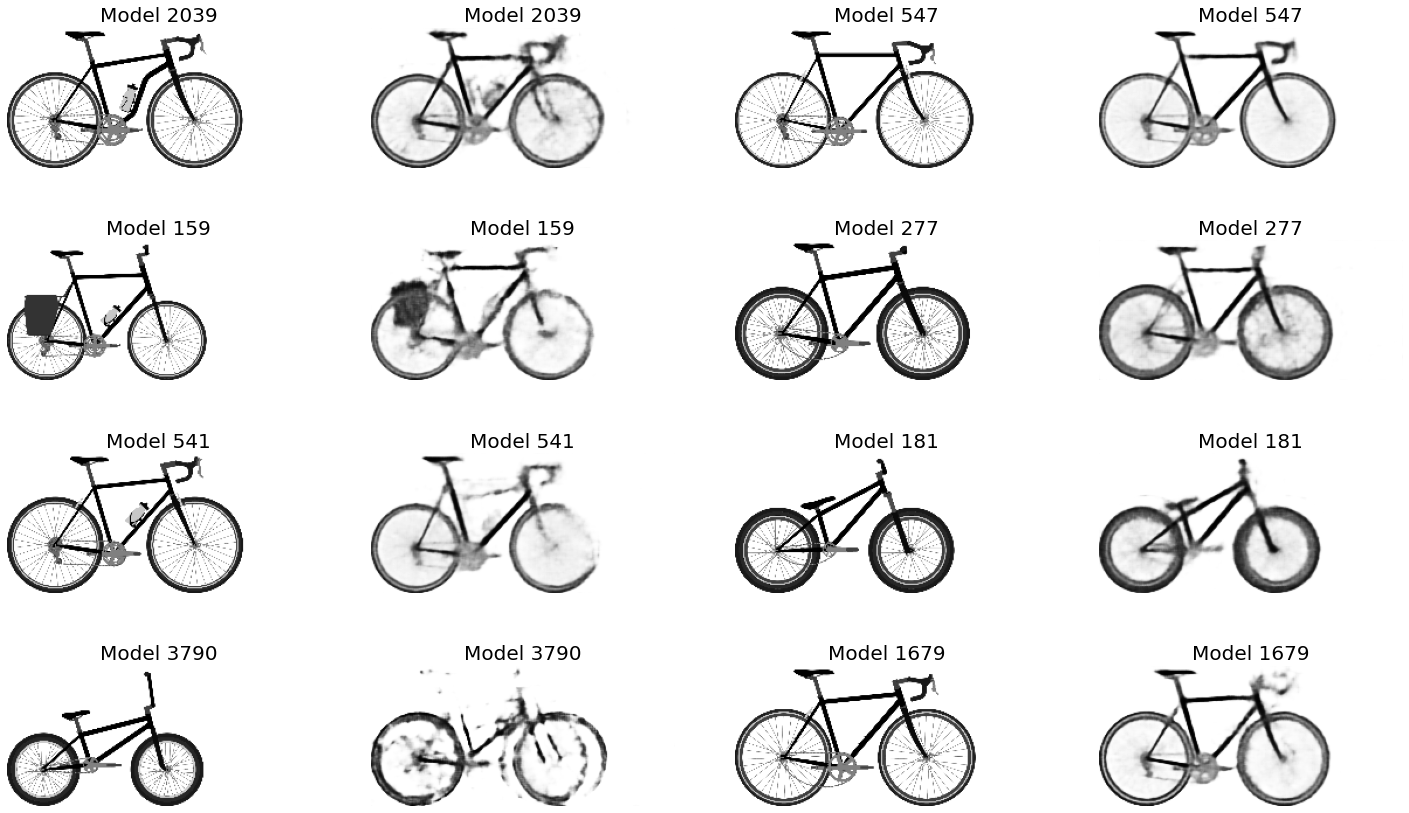

In [19]:
preds=tf.sigmoid(imageVAE.layers[2].predict(Regressor.predict(param_val[:8])))
plotcomparison(preds, image_val[:8], param_val.index[:8])

In [20]:
score=0
preds=tf.sigmoid(imageVAE.layers[2].predict(Regressor.predict(param_val)))
for i in range(len(param_val.index)):
    score+=tf.image.ssim(image_val[i], preds[i], 1)
score=score/len(param_val.index)
print(score)

tf.Tensor(0.5130579, shape=(), dtype=float32)


In [21]:
x_test=pd.read_csv("./BIKED_processed.csv", index_col=0)
param_test = pd.DataFrame(x_test, columns=x_test.columns,index=x_test.index.values).astype('float32')

with open("images.npy", 'rb') as f:
    images = np.load(f)
images=tf.cast(tf.expand_dims(images, -1), tf.float32)

FileNotFoundError: [Errno 2] No such file or directory: './BIKED_processed.csv'

In [ ]:
preds=tf.sigmoid(imageVAE.layers[2].predict(Regressor.predict(param_test[:8])))
plotcomparison(preds, image_test[:8], param_test.index[:8])